# Customer Segmentation usinng RFM Analysis

In [94]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import lifetimes
import squarify

In [18]:
order_products_prior = pd.read_csv("order_products__prior.csv")
orders = pd.read_csv("orders.csv")

In [27]:
df = pd.merge(orders,order_products_prior, on=['order_id','order_id'])

In [34]:
df_order = df.groupby('order_id').count()[['product_id']]
df_order.rename(columns = {'order_id': 'order_id',
                     'product_id': 'Total_products'},inplace = True)

In [35]:
user_data = orders.join(df_order, how = 'inner', on = 'order_id')
user_data.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,Total_products
0,2539329,1,prior,1,2,8,NaN,5
1,2398795,1,prior,2,3,7,15.0,6
2,473747,1,prior,3,3,12,21.0,5
3,2254736,1,prior,4,4,7,29.0,5
4,431534,1,prior,5,4,15,28.0,8


In [36]:
frequency = user_data.groupby('user_id')['order_number'].max()
recency = round(user_data.groupby('user_id')['days_since_prior_order'].mean(), 0)
monetary_value = user_data.groupby('user_id')['Total_products'].sum()
T = user_data.groupby('user_id')['days_since_prior_order'].sum()

In [37]:
rfm = pd.concat([frequency, recency, monetary_value, T], axis = 1)
rfm.columns = ['frequency', 'recency', 'monetary_value', 'T']
rfm.head()

,frequency,recency,monetary_value,T
user_id,,,,
1,10,20.0,59,176.0
2,14,15.0,195,198.0
3,12,12.0,88,133.0
4,5,14.0,18,55.0
5,4,13.0,37,40.0


In [38]:
rfm.isna().sum()

frequency         0
recency           0
monetary_value    0
T                 0
dtype: int64

In [39]:
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import calibration_and_holdout_data, summary_data_from_transaction_data

In [40]:
#BG/NBD
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(rfm['frequency'], rfm['recency'], rfm['T'])

<lifetimes.BetaGeoFitter: fitted with 206209 subjects, a: 32.06, alpha: 0.32, b: 492.80, r: 0.62>

<AxesSubplot:title={'center':'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

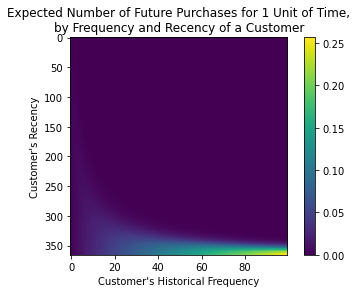

In [43]:
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf)

<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

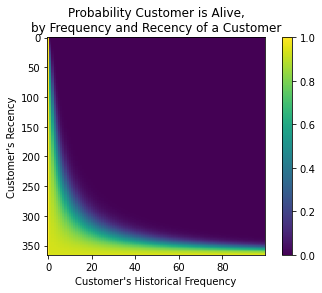

In [44]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

<AxesSubplot:title={'center':'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

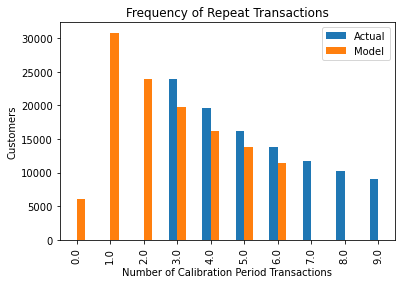

In [45]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [41]:
#GG
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(rfm['frequency'],
        rfm['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 206209 subjects, p: 0.31, q: 1.97, v: 639.22>

In [42]:
#CLV model
clv = ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    rfm['frequency'],
    rfm['recency'],
    rfm['T'],
    rfm['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
)

rfm['clv'] = clv

#Print the top 10 most valued customers
rfm.sort_values('clv', ascending=False).head(10)

,frequency,recency,monetary_value,T,clv
user_id,,,,,
9515,3,0.0,39,0.0,1944.286761
115420,3,0.0,39,0.0,1944.286761
58934,3,0.0,25,0.0,1836.302573
121915,3,0.0,24,0.0,1828.589416
179078,3,0.0,24,0.0,1828.589416
133075,3,0.0,21,0.0,1805.449948
125717,3,0.0,15,0.0,1759.171010
131603,3,0.0,14,0.0,1751.457853
137150,3,0.0,12,0.0,1736.031541


In [55]:
rfm_df = rfm.drop(['T','clv'], axis=1)
rfm_df.columns = ['Frequency', 'Recency', 'Monetary']

In [56]:
rfm_df.head()

,Frequency,Recency,Monetary
user_id,,,
1,10,20.0,59
2,14,15.0,195
3,12,12.0,88
4,5,14.0,18
5,4,13.0,37


In [57]:
quantiles = rfm_df.quantile(q=[0.25,0.5,0.75])
quantiles

,Frequency,Recency,Monetary
0.25,5.0,9.0,39.0
0.50,9.0,14.0,83.0
0.75,19.0,20.0,188.0


In [58]:
quantiles.to_dict()

{'Frequency': {0.25: 5.0, 0.5: 9.0, 0.75: 19.0},
 'Recency': {0.25: 9.0, 0.5: 14.0, 0.75: 20.0},
 'Monetary': {0.25: 39.0, 0.5: 83.0, 0.75: 188.0}}

In [59]:
# Arguments (x = value, p = recency, monetary_value, frequency, d = quartiles dict)
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

In [60]:
rfm_segmentation = rfm_df
rfm_segmentation['R_Quartile'] = rfm_segmentation['Recency'].apply(RScore, args=('Recency',quantiles,))
rfm_segmentation['F_Quartile'] = rfm_segmentation['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
rfm_segmentation['M_Quartile'] = rfm_segmentation['Monetary'].apply(FMScore, args=('Monetary',quantiles,))

In [61]:
rfm_segmentation.head()

,Frequency,Recency,Monetary,R_Quartile,F_Quartile,M_Quartile
user_id,,,,,,
1,10,20.0,59,2,3,2
2,14,15.0,195,2,3,4
3,12,12.0,88,3,3,3
4,5,14.0,18,3,1,1
5,4,13.0,37,3,1,1


In [96]:
rfm_segmentation['RFMScore'] = rfm_segmentation.R_Quartile.map(str) + rfm_segmentation.F_Quartile.map(str) + rfm_segmentation.M_Quartile.map(str)
rfm_segmentation.head()


,Frequency,Recency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Segment
user_id,,,,,,,,
1,10,20.0,59,2,3,2,232,Others
2,14,15.0,195,2,3,4,234,Others
3,12,12.0,88,3,3,3,333,Others
4,5,14.0,18,3,1,1,311,Others
5,4,13.0,37,3,1,1,311,Others


In [82]:
segment_dict = {
    'Best Customers':'444',      # Highest frequency as well as monetary value with least recency
    'Loyal Customers':'344',    # High frequency as well as monetary value with good recency
    'Potential Loyalists':'434', # High recency and monetary value, average frequency
    'Big Spenders':'334',        # High monetary value but good recency and frequency values
    'At Risk Customers':'244',   # Customer's shopping less often now who used to shop a lot
    'Can’t Lose Them':'144',      # Customer's shopped long ago who used to shop a lot.
    'Recent Customers':'443',    # Customer's who recently started shopping a lot but with less monetary value
    'Lost Cheap Customers':'122' # Customer's shopped long ago but with less frequency and monetary value
}

In [89]:
dict_segment = dict(zip(segment_dict.values(),segment_dict.keys()))
rfm_segmentation['Segment'] = rfm_segmentation.RFMScore.map(lambda x: dict_segment.get(x))
rfm_segmentation['Segment']
rfm_segmentation.fillna('Others', inplace = True)
rfm_segmentation.reset_index()

,user_id,Frequency,Recency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Segment
0,1,10,20.0,59,2,3,2,232,Others
1,2,14,15.0,195,2,3,4,234,Others
2,3,12,12.0,88,3,3,3,333,Others
3,4,5,14.0,18,3,1,1,311,Others
4,5,4,13.0,37,3,1,1,311,Others
...,...,...,...,...,...,...,...,...,...
206204,206205,3,20.0,32,2,1,1,211,Others
206205,206206,67,4.0,285,4,4,4,444,Best Customers
206206,206207,16,14.0,223,3,3,4,334,Big Spenders
206207,206208,49,7.0,677,4,4,4,444,Best Customers


In [90]:
rfm_segments = rfm_segmentation[rfm_segmentation.Segment!='Others'].reset_index().groupby('Segment')['user_id'].count().reset_index(name='counts')
rfm_segments.iloc[:8]

,Segment,counts
0,At Risk Customers,1532
1,Best Customers,24989
2,Big Spenders,3479
3,Lost Cheap Customers,6278
4,Loyal Customers,12509
5,Potential Loyalists,1775
6,Recent Customers,3945


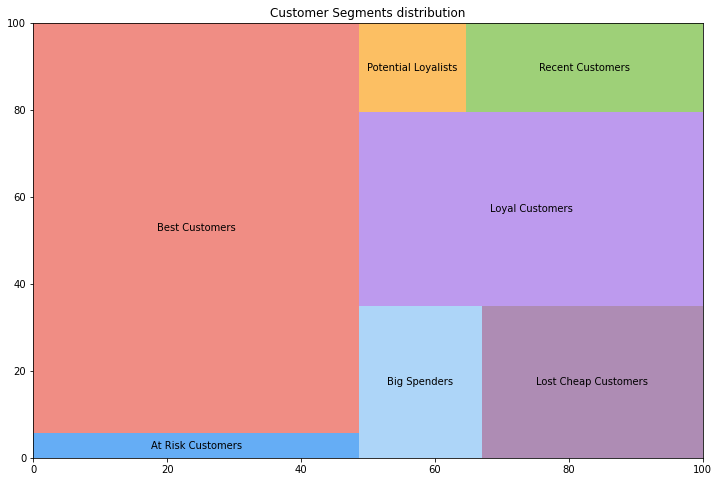

In [95]:
segment = list(rfm_segments.iloc[:8].Segment)
score = list(rfm_segments.iloc[:8].counts)
color_list = ["#248af1", "#eb5d50", "#8bc4f6", "#8c5c94", "#a170e8", "#fba521", "#75bc3f"]
plt.figure(figsize=(12,8))
plt.title('Customer Segments distribution')
squarify.plot(sizes=score, label=segment,color=color_list, alpha=0.7)

plt.show()

## Recommendations
### Best Customers
- We can give a reward them for their multiple purchases.
- We can Suggest them to "Refer a friend" and can give points or rewards for both.
- They can be the early adopters to new products

### Lost Cheap Customers
- We can send them personalized Emails to encourage them to order by giving some discounts.
- We can create campaigns by sending out feedback surveys with which we can analyze the issue
- Once we identify the problem, work to correct it. Once corrected, spin it into a marketing campaign.

### Big Spenders
- We can give them early access to good deals.
- Award higher status
- Leverage better deals

### Loyal Customers
- Loyalty cards can be awarded to them and later the points that were accumulated can be converted to discounts.
- Potential Loyalists
- Offer Membership or Loyalty Programs
- Recommend related products to upsell them

### At Risk Customers
- Use a new channel to reach out like social media targeted Ads
- Winback campaigns can be setup